<a href="https://colab.research.google.com/github/sandhya111205/yolo_custom/blob/main/DrowsinessDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Driver Fatigue Detection using CNN

Implemented a Convolutional Neural Network (CNN) to classify eyes as either open or closed, also employed facial recognition techniques to identify eye coordinates in real time.


## Setup the environment

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install tensorflow scikit-learn opencv-python numpy matplotlib face_recognition

---

## Load images for training

The `load_eye_images` function is employed to read images from a target folder, resize them to a consistent size (80x80 pixels), and assign labels based on the provided binary flag for eye state (0 for open, 1 for closed).



In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def load_eye_images(source_path, eye_state=0):
    """
    Returns:
        list: List of eye image data with corresponding labels.
    """
    image_count = 0
    error_count = 0
    eye_images = []

    for filename in os.listdir(source_path):
        try:
            img = cv2.imread(os.path.join(source_path, filename))
            img = cv2.resize(img, (80, 80))
            eye_images.append([img, eye_state])
        except Exception as e:
            error_count += 1
            print(f'Error Count: {error_count}, Exception: {e}')
            continue

        image_count += 1
        if image_count % 500 == 0:
            print(f'Successful Image Import Count: {image_count}')

    return eye_images


---

## Prepare the data for training

Now, we need to organize and prepare the image data for model training. Images from folders representing open and closed eyes are loaded using the `load_eye_images` function. The data is then converted into NumPy arrays, normalized, and split into training and testing sets.

### Eye open

In [6]:
import zipfile
import os

def unzip_dataset(zip_file, destination):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(destination)

if __name__ == "__main__":
    zip_file = "/content/drive/MyDrive/project/new/dataset.zip"
    destination = "/content/drive/MyDrive/project/new/dataset"

    if not os.path.exists(destination):
        os.makedirs(destination)

    unzip_dataset(zip_file, destination)
    print("Dataset has been successfully extracted.")


Dataset has been successfully extracted.


Successful Image Import Count: 500


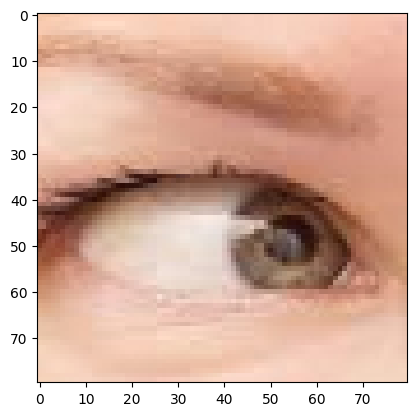

In [7]:
open_eye_folder = "/content/drive/MyDrive/project/new/dataset/OpenEye"
open_eye_data = load_eye_images(open_eye_folder, eye_state=0)

# sample
img, label = open_eye_data[20]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Eye closed

Successful Image Import Count: 500


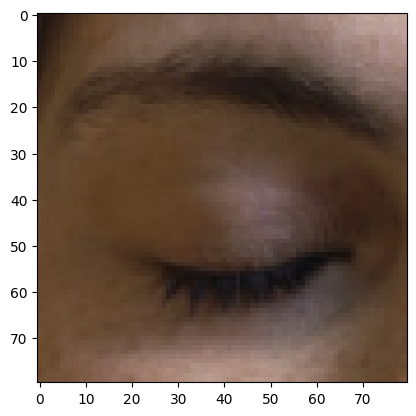

In [8]:
closed_eye_folder = "/content/drive/MyDrive/project/new/dataset/ClosedEye"
closed_eye_data = load_eye_images(closed_eye_folder, eye_state=1)

# sample
img, label = closed_eye_data[10]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [9]:
eye_data = closed_eye_data + open_eye_data

X = []
y = []
for features, label in eye_data:
     X.append(features)
     y.append(label)

# Prepare data
X = np.array(X).reshape(-1, 80, 80, 3) / 255.0
y = np.array(y)

In [10]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)


---

## Build a Convolutional Neural Network (CNN) model

We need to build a Convolutional Neural Network (CNN) Model for drowsiness detection. The model consists of convolutional layers, max-pooling layers, and dense layers. It is compiled using the Adam optimizer and binary crossentropy loss function.


In [11]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout

In [12]:
# Build the CNN model
cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 3)))
cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC(curve='PR')])

In [13]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 76, 76, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 74, 74, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 37, 37, 32)        0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 35, 35, 32)        9248      
                                                                 
 conv2d_4 (Conv2D)           (None, 33, 33, 32)        9248      
                                                        


---

## Model Training and Evaluation with Accuracy Plotting

The fit method is used to train the model with specified batch size, validation data, and number of epochs. The evaluate method calculates the loss and specified metrics on the test data.

### Train the model

In [14]:
history = cnn_model.fit(X_train, y_train, batch_size=800, validation_data=(X_test, y_test), epochs=50, verbose=1)

Epoch 1/50
2/2 [==============================] - 33s 9s/step - loss: 0.6930 - auc: 0.5294 - val_loss: 0.6672 - val_auc: 0.9297
Epoch 2/50
2/2 [==============================] - 1s 217ms/step - loss: 0.6777 - auc: 0.5991 - val_loss: 0.5990 - val_auc: 0.9312
Epoch 3/50
2/2 [==============================] - 1s 202ms/step - loss: 0.6484 - auc: 0.6591 - val_loss: 0.5481 - val_auc: 0.9504
Epoch 4/50
2/2 [==============================] - 1s 206ms/step - loss: 0.5951 - auc: 0.8096 - val_loss: 0.5485 - val_auc: 0.9540
Epoch 5/50
2/2 [==============================] - 1s 201ms/step - loss: 0.5631 - auc: 0.8998 - val_loss: 0.4198 - val_auc: 0.9558
Epoch 6/50
2/2 [==============================] - 1s 210ms/step - loss: 0.4625 - auc: 0.8916 - val_loss: 0.3071 - val_auc: 0.9652
Epoch 7/50
2/2 [==============================] - 1s 291ms/step - loss: 0.4213 - auc: 0.8739 - val_loss: 0.2496 - val_auc: 0.9698
Epoch 8/50
2/2 [==============================] - 1s 205ms/step - loss: 0.3266 - auc: 0.9334

### Evaluate the model

In [15]:
cnn_model.evaluate(X_test, y_test, verbose=1)

12/12 [==============================] - 1s 27ms/step - loss: 0.1822 - auc: 0.9662


[0.18216775357723236, 0.9661712050437927]

### Plot the accuracy

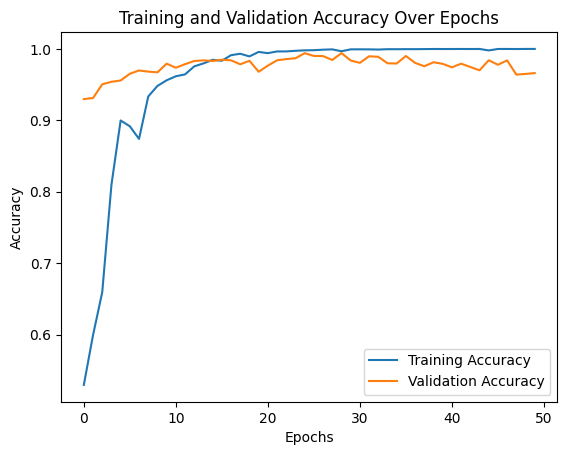

In [16]:
training_accuracy = history.history['auc']
validation_accuracy = history.history['val_auc']

# Plot accuracy over epochs
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

### Save the model

In [17]:
cnn_model.save('drowsiness_model.keras')


---

## Alert system

Frames from the webcam are processed in real-time, and the model predicts the state of the eyes. The loop also handles visual feedback and alerts based on the prediction


### Load trained model

In [18]:
trained_model = keras.models.load_model('drowsiness_model.keras')


### Extract eye region for prediction

The eyes are cropped from a webcam frame. It utilizes the `face_recognition` library to detect facial features and accurately crop the eyes.

In [19]:
import face_recognition

def extract_eye_region_for_prediction(frame):

    # Detect facial landmarks
    facial_landmarks_list = face_recognition.face_landmarks(frame)

    if not facial_landmarks_list:
        return

    # Get left and right eye coordinates
    try:
        left_eye_coordinates = facial_landmarks_list[0]['left_eye']
        right_eye_coordinates = facial_landmarks_list[0]['right_eye']
    except KeyError:
        return

    # Draw rectangles around each eye
    for eye_coordinates in [left_eye_coordinates, right_eye_coordinates]:
        x_max = max([x for x, y in eye_coordinates])
        x_min = min([x for x, y in eye_coordinates])
        y_max = max([y for x, y in eye_coordinates])
        y_min = min([y for x, y in eye_coordinates])

        # Calculate the range of x and y coordinates
        x_range = x_max - x_min
        y_range = y_max - y_min

        # Ensure the full eye is captured by calculating coordinates of a square with a 50% cushion
        if x_range > y_range:
            right_bound = round(0.5 * x_range) + x_max
            left_bound = x_min - round(0.5 * x_range)
            bottom_bound = round((right_bound - left_bound - y_range) / 2) + y_max
            top_bound = y_min - round((right_bound - left_bound - y_range) / 2)
        else:
            bottom_bound = round(0.5 * y_range) + y_max
            top_bound = y_min - round(0.5 * y_range)
            right_bound = round((bottom_bound - top_bound - x_range) / 2) + x_max
            left_bound = x_min - round((bottom_bound - top_bound - x_range) / 2)

        # Draw rectangle around the eye
        cv2.rectangle(frame, (left_bound, top_bound), (right_bound, bottom_bound), (255, 0, 0), 2)

    # Crop the image according to the determined coordinates
    cropped_eye_region = frame[top_bound:bottom_bound + 1, left_bound:right_bound + 1]

    # Resize the cropped image to 80x80 pixels
    resized_cropped_eye_region = cv2.resize(cropped_eye_region, (80, 80))

    # Reshape the image for model prediction
    image_for_prediction = resized_cropped_eye_region.reshape(-1, 80, 80, 3)

    return image_for_prediction

### Initialize the webcam

In [20]:
def initialize_webcam():
    cap = cv2.VideoCapture('/content/drive/MyDrive/project/video.mp4')
    w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

    if not cap.isOpened():
        raise IOError('Cannot open webcam')

    return cap, w, h


### Run drowsiness detection

It uses computer vision to detect drowsiness from a webcam feed. It continuously captures and processes frames, extracting the eye region for analysis. A pre-trained model predicts eye states, triggering a visual alert for prolonged eye closure, indicating potential drowsiness. (*App can be closed by pressing 'esc'*)

1/1 [==============================] - 0s 41ms/step


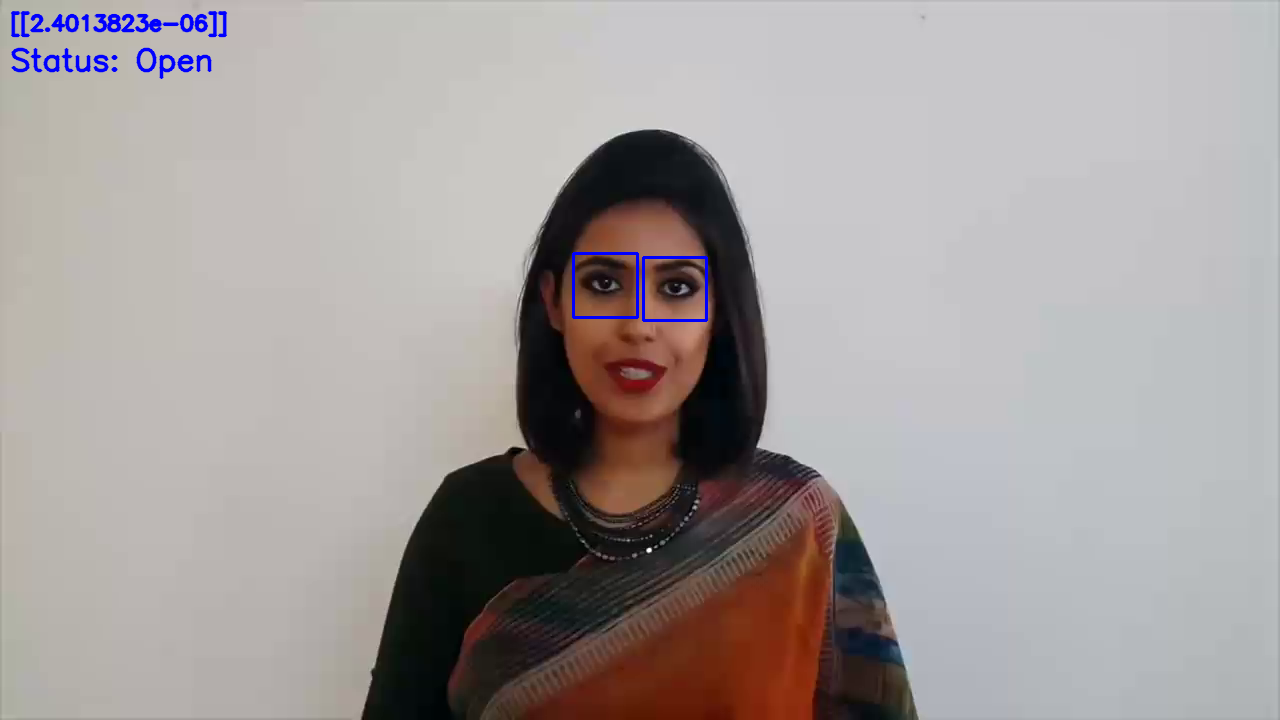

1/1 [==============================] - 0s 33ms/step


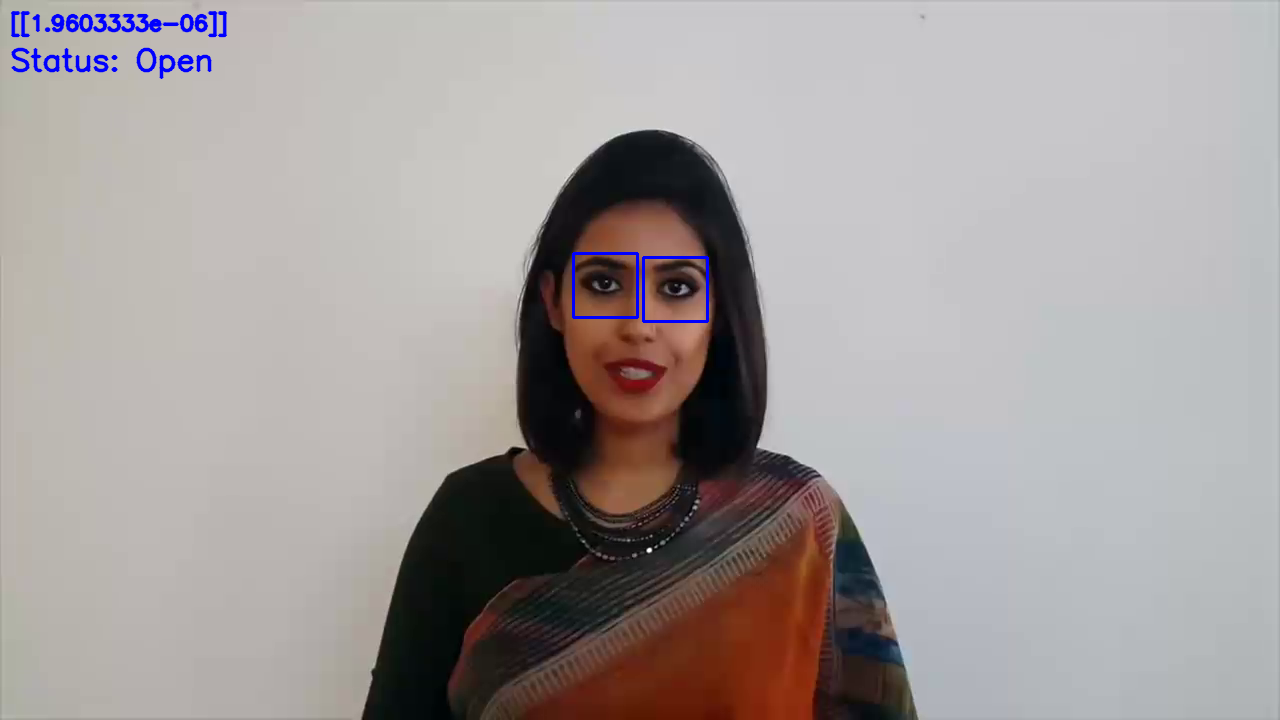

1/1 [==============================] - 0s 19ms/step


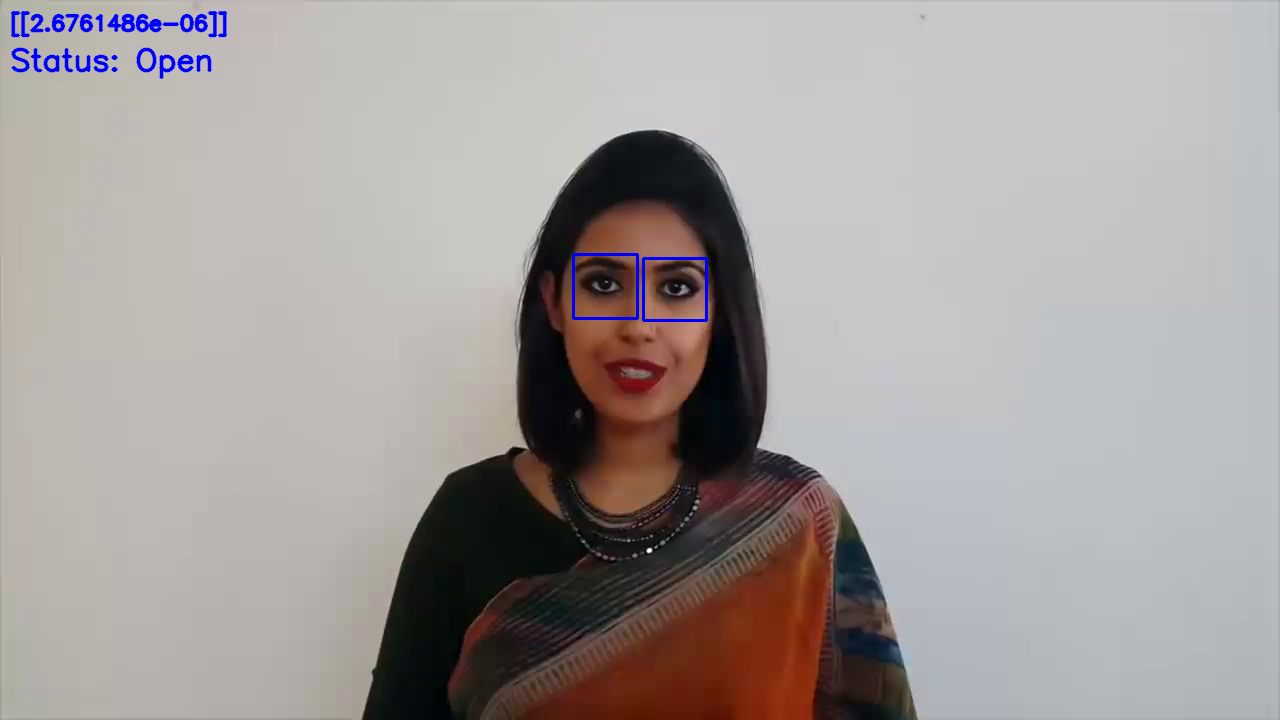

1/1 [==============================] - 0s 20ms/step


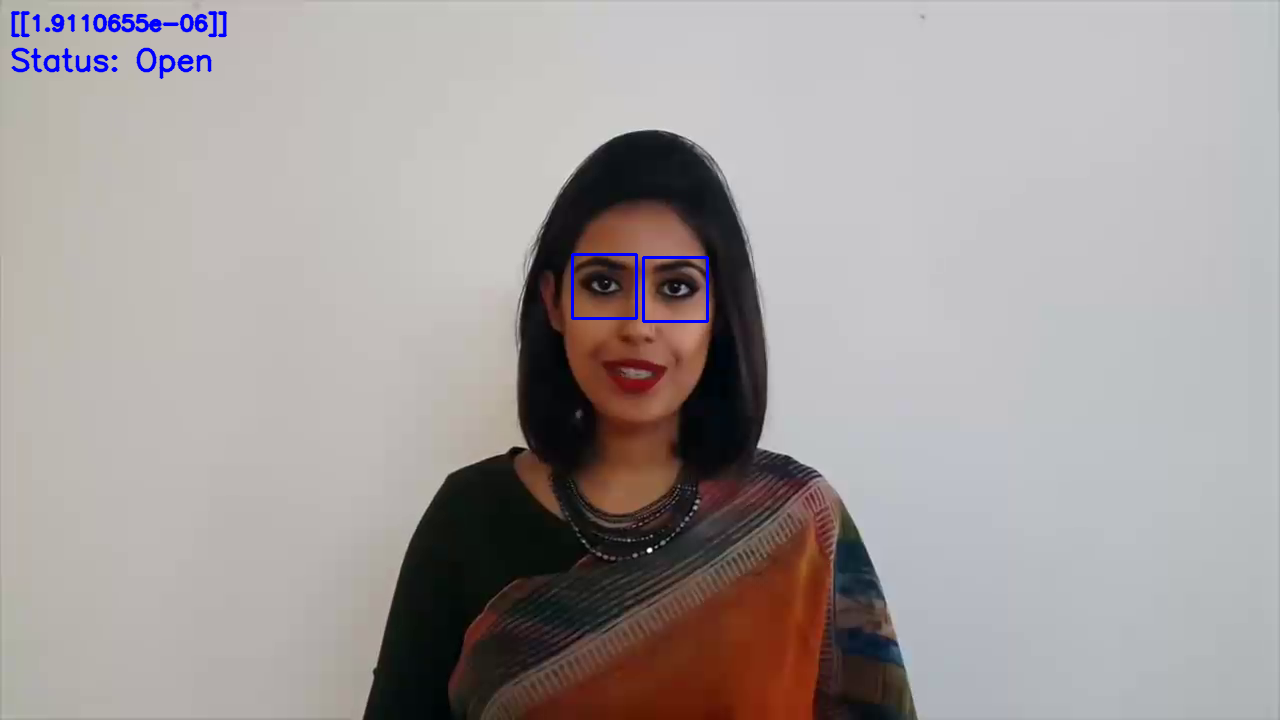

1/1 [==============================] - 0s 19ms/step


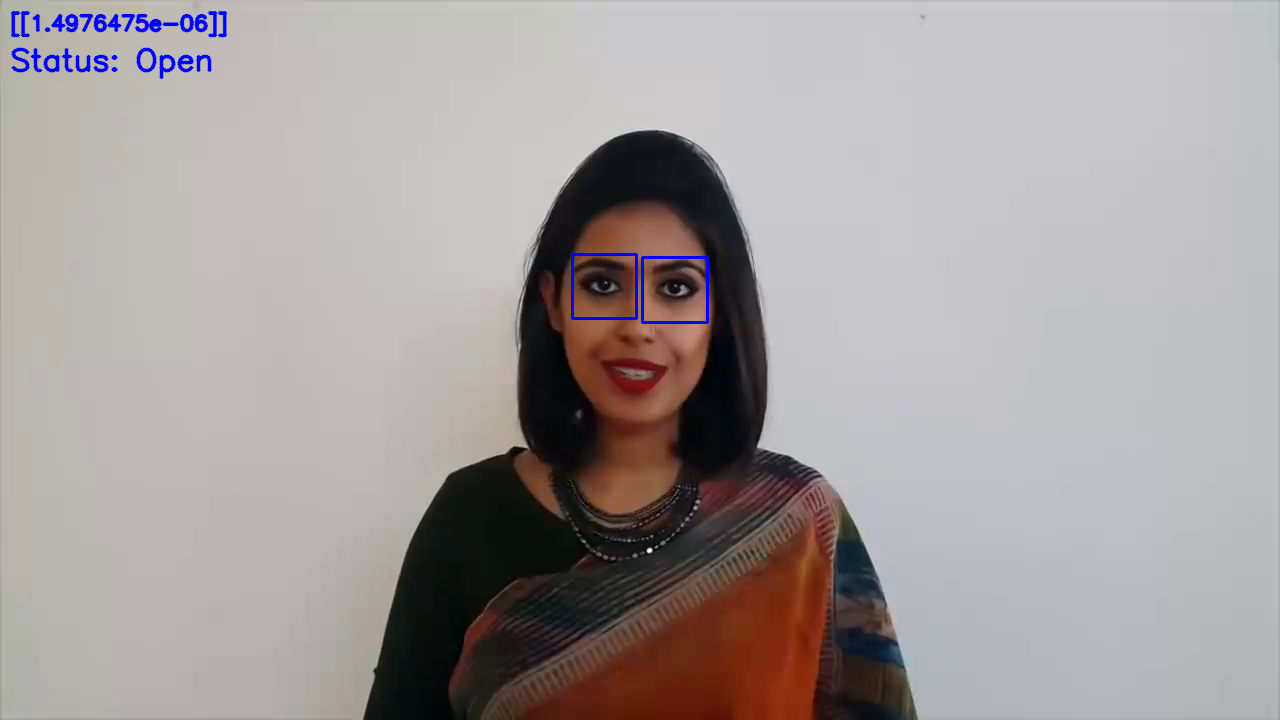

KeyboardInterrupt: 

In [26]:
# Initialize webcam
from google.colab.patches import cv2_imshow
webcam, width, height = initialize_webcam()

# Initialize counters
frame_count = 0
blink_counter = 0

# Run a continuous loop while the webcam is active
while True:
    # Capture frames from the webcam
    ret, frame = webcam.read()

    # Use only every other frame to manage speed and memory usage
    if frame_count == 0:
        frame_count += 1
        pass
    else:
        frame_count = 0
        continue

    # Process the frame to get the eye for prediction
    eye_image = extract_eye_region_for_prediction(frame)
    try:
        eye_image = eye_image / 255.0
    except:
        continue

    # Get prediction from the trained model
    prediction = trained_model.predict(eye_image)

    # Display status based on the prediction ("Open Eyes" or "Closed Eyes")
    if prediction < 0.2:
        blink_counter = 0
        status = 'Open'

    else:
        blink_counter += 1
        status = 'Closed'

        # If the blink counter exceeds 2, show an alert for drowsiness
        if blink_counter > 5:
            # Show alert message on Screen
            cv2.rectangle(frame, (round(width / 2) - 160, round(height) - 200), (round(width / 2) + 175, round(height) - 120), (0, 0, 255), -1)
            cv2.putText(frame, "Blink, Don't Sleep!", (round(width / 2) - 136, round(height) - 146), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_4)
            cv2_imshow(frame)
            k = cv2.waitKey(1)
            blink_counter = 1
            continue

    # Show prediction on Screen
    cv2.putText(frame, f'{prediction}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2, cv2.LINE_AA)
    # Show status (Open or Closed on Screen)
    cv2.putText(frame, 'Status: ' + status, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    # Display the processed frame
    cv2_imshow(frame)

    # Exit the loop on pressing the 'Esc' key
    if cv2.waitKey(1) & 0xFF == 27:
        break

# Release the webcam and close all windows
webcam.release()
cv2.destroyAllWindows()
